In [2]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor


In [3]:
data_dir = 'data'
users = os.listdir(data_dir)
users.pop(0)
users = sorted(users, key=lambda x: int(x.split('_')[1]))
print(users)

['user_1', 'user_2', 'user_3', 'user_4', 'user_5', 'user_6', 'user_7', 'user_8', 'user_9', 'user_10', 'user_11', 'user_12', 'user_13', 'user_14', 'user_15', 'user_16', 'user_17', 'user_18', 'user_19', 'user_20', 'user_21', 'user_22']


In [4]:
# Part 1: Examine relationship between hormone levels and sleep measures

# Extract data from folders
data_1 = []
for user in users:
    user_data = {'user_id': user}
    
    # Extract user info
    user_info = pd.read_csv(data_dir + '/' + user + '/' + 'user_info.csv')
    user_info_cols = ['Gender', 'Age', 'Weight', 'Height']
    for i in user_info_cols:
        user_data[i] = user_info.loc[0, i] # No missing data
    
    # Extract sleep info
    sleep_info = pd.read_csv(data_dir + '/' + user + '/' + 'sleep.csv')
    sleep_info_cols_mean = ['Latency', 'Efficiency', 'Number of Awakenings', 'Average Awakening Length', 'Movement Index', 'Fragmentation Index', 'Sleep Fragmentation Index']
    sleep_info_cols_sum = ['Total Minutes in Bed', 'Total Sleep Time (TST)']

    if sleep_info.empty: 
        for i in sleep_info_cols_mean:
            user_data[i] = np.nan # handle missing data for user 11
        for i in sleep_info_cols_sum:
            user_data[i] = np.nan
    else:
        for i in sleep_info_cols_mean:
            user_data[i] = sleep_info[i].mean()
        for i in sleep_info_cols_sum:
            user_data[i] = sleep_info[i].sum()
    
    # Extract info about MEQ and PSQI from questionnaire.
    ques_info = pd.read_csv(data_dir + '/' + user + '/' + 'questionnaire.csv')
    ques_info_cols = ['MEQ', 'Pittsburgh', 'Daily_stress', 'STAI1', 'STAI2']
    for i in ques_info_cols:
        user_data[i] = ques_info.loc[0, i] # No missing data
    
    # Extract info about hormone in saliva
    try:
        saliva_info = pd.read_csv(data_dir + '/' + user + '/' + 'saliva.csv')
        before_sleep = saliva_info[saliva_info['SAMPLES'] == 'before sleep']
        user_data['Cortisol Before Sleep'] = before_sleep.loc[0, 'Cortisol NORM']
        user_data['Melatonin Before Sleep'] = before_sleep.loc[0, 'Melatonin NORM']
        after_sleep = saliva_info[saliva_info['SAMPLES'] == 'wake up']
        user_data['Cortisol After Sleep'] = after_sleep.loc[1, 'Cortisol NORM']
        user_data['Melatonin After Sleep'] = after_sleep.loc[1, 'Melatonin NORM']
    except FileNotFoundError: # handle missing file for user 21
        cols = ['Cortisol Before Sleep', 'Melatonin Before Sleep', 'Cortisol After Sleep', 'Melatonin After Sleep']
        for c in cols:
            user_data[c] = np.nan

    # print(user)
    
    data_1.append(user_data)
    
df1 = pd.DataFrame(data_1)

# Raw extracted data:
df1.info()
df1.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    22 non-null     object 
 1   Gender                     22 non-null     object 
 2   Age                        22 non-null     int64  
 3   Weight                     22 non-null     int64  
 4   Height                     22 non-null     int64  
 5   Latency                    21 non-null     float64
 6   Efficiency                 21 non-null     float64
 7   Number of Awakenings       21 non-null     float64
 8   Average Awakening Length   21 non-null     float64
 9   Movement Index             21 non-null     float64
 10  Fragmentation Index        21 non-null     float64
 11  Sleep Fragmentation Index  21 non-null     float64
 12  Total Minutes in Bed       21 non-null     float64
 13  Total Sleep Time (TST)     21 non-null     float64
 

,user_id,Gender,Age,Weight,Height,Latency,Efficiency,Number of Awakenings,Average Awakening Length,Movement Index,...,Total Sleep Time (TST),MEQ,Pittsburgh,Daily_stress,STAI1,STAI2,Cortisol Before Sleep,Melatonin Before Sleep,Cortisol After Sleep,Melatonin After Sleep
0,user_1,M,29,65,169,0.0,89.645,9.0,2.11,9.0055,...,340.0,47.0,5.0,23.0,41.0,43.0,0.034137,1.738385e-08,0.077939,6.747893e-09
1,user_2,M,27,95,183,4.0,73.490,18.0,4.67,15.0600,...,244.0,52.0,7.0,26.0,24.0,39.0,0.021186,1.676342e-08,0.261252,2.853905e-08
2,user_3,M,34,70,174,3.0,79.230,16.0,5.56,18.9620,...,351.0,59.0,8.0,11.0,27.0,27.0,0.012142,5.714439e-09,0.043799,3.603324e-09
3,user_4,M,27,76,180,4.0,85.520,28.0,1.79,8.8470,...,319.0,60.0,4.0,10.0,28.0,40.0,0.023772,2.149747e-08,0.041724,8.055610e-09
4,user_5,M,25,80,196,0.0,85.710,21.0,2.76,11.5760,...,348.0,52.0,8.0,41.0,54.0,47.0,0.022310,2.396239e-08,0.089516,1.096777e-08


In [5]:
# Drop user 11 and user 21
df1 = df1.dropna()

# Drop 'Gender' since all participants are male 
dropped_cols = ['Gender']
df1 = df1.drop(columns=dropped_cols)

df1.info()
df1.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 0 to 21
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    20 non-null     object 
 1   Age                        20 non-null     int64  
 2   Weight                     20 non-null     int64  
 3   Height                     20 non-null     int64  
 4   Latency                    20 non-null     float64
 5   Efficiency                 20 non-null     float64
 6   Number of Awakenings       20 non-null     float64
 7   Average Awakening Length   20 non-null     float64
 8   Movement Index             20 non-null     float64
 9   Fragmentation Index        20 non-null     float64
 10  Sleep Fragmentation Index  20 non-null     float64
 11  Total Minutes in Bed       20 non-null     float64
 12  Total Sleep Time (TST)     20 non-null     float64
 13  MEQ                        20 non-null     float64
 14  P

,Age,Weight,Height,Latency,Efficiency,Number of Awakenings,Average Awakening Length,Movement Index,Fragmentation Index,Sleep Fragmentation Index,...,Total Sleep Time (TST),MEQ,Pittsburgh,Daily_stress,STAI1,STAI2,Cortisol Before Sleep,Melatonin Before Sleep,Cortisol After Sleep,Melatonin After Sleep
count,20.00000,20.000000,20.000000,20.0000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000,2.000000e+01
mean,25.90000,73.300000,179.850000,1.6500,83.219250,19.850000,3.739000,14.069925,11.116800,25.186725,...,330.650000,50.700000,5.300000,33.050000,35.500000,39.550000,0.027426,8.644841e-09,0.072575,6.830459e-09
std,7.46853,9.603179,8.449696,1.7252,6.640638,9.985648,2.425216,4.169914,9.145866,10.995602,...,72.518074,6.728572,2.028741,16.744127,8.738903,10.733494,0.031122,6.721024e-09,0.053090,6.528505e-09
min,0.00000,60.000000,169.000000,0.0000,73.490000,4.000000,1.750000,8.095000,0.000000,8.095000,...,236.000000,38.000000,2.000000,10.000000,24.000000,0.000000,0.012017,1.629907e-09,0.019659,0.000000e+00
25%,24.75000,66.500000,175.000000,0.0000,76.185000,12.750000,2.252500,10.318500,3.571500,17.769500,...,303.500000,45.750000,4.000000,22.750000,28.750000,39.000000,0.015134,3.490723e-09,0.042635,2.504329e-09
50%,27.00000,70.000000,180.000000,1.0000,84.640000,19.000000,2.875000,14.932000,11.580000,23.792000,...,337.500000,49.500000,5.000000,31.500000,33.000000,42.000000,0.019831,5.912706e-09,0.059983,5.184523e-09
75%,27.50000,80.000000,183.000000,3.0000,88.400000,22.500000,4.415000,17.540000,16.603750,32.146250,...,344.250000,55.750000,7.000000,41.000000,41.000000,45.250000,0.024321,1.190672e-08,0.083025,8.432381e-09
max,40.00000,95.000000,205.000000,4.0000,94.230000,44.000000,12.250000,20.669000,28.125000,45.526000,...,578.000000,64.000000,9.000000,74.000000,54.000000,49.000000,0.155777,2.396239e-08,0.261252,2.853905e-08


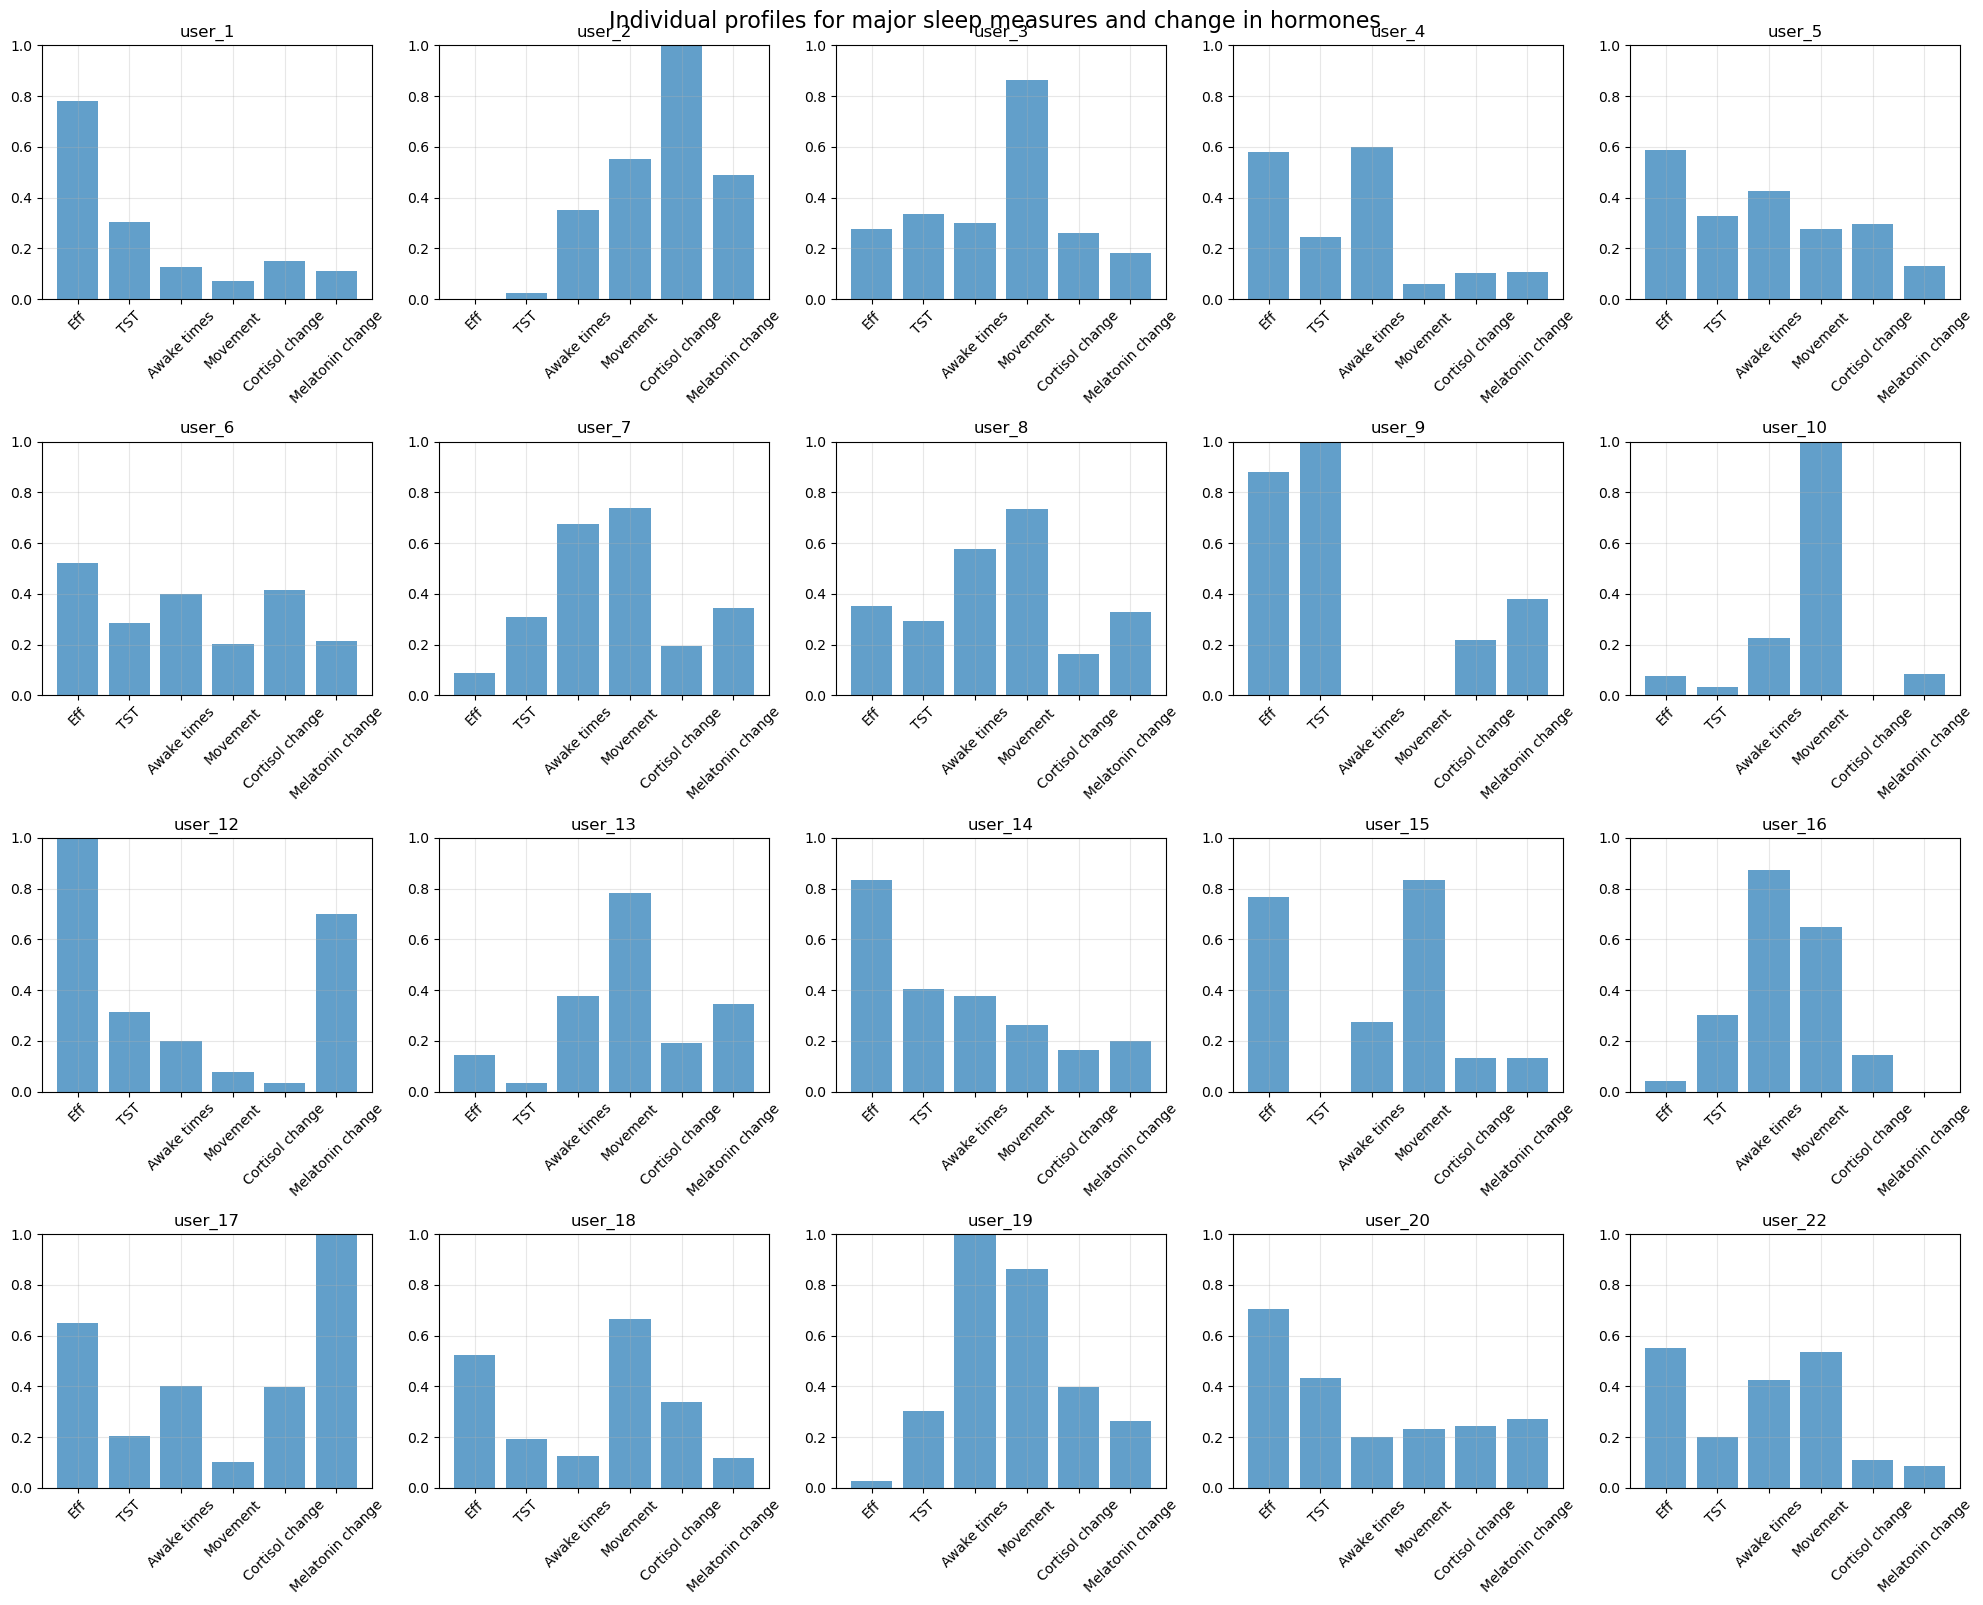

In [6]:
# Considering numerical data
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

for i, user in enumerate(df1['user_id'].unique()[:20]):
    # add cortisol change and melatonin change.
    df1_extended = df1.copy()
    df1_extended['Cortisol change'] = (df1['Cortisol After Sleep']-df1['Cortisol Before Sleep'])/df1['Cortisol Before Sleep']*100
    df1_extended['Melatonin change'] = (df1['Melatonin After Sleep']-df1['Melatonin Before Sleep'])/df1['Melatonin Before Sleep']*100
    
    user_data = df1_extended[df1_extended['user_id'] == user]
    
    metrics = ['Efficiency', 'Total Sleep Time (TST)', 'Number of Awakenings', 'Movement Index', 'Cortisol change', 'Melatonin change']
    values = [user_data[m].values[0] for m in metrics]
    
    norms = [(v - df1_extended[m].min()) / (df1_extended[m].max() - df1_extended[m].min()) for v, m in zip(values, metrics)]
    
    axes[i].bar(range(len(metrics)), norms, alpha=0.7)
    axes[i].set_xticks(range(len(metrics)))
    axes[i].set_xticklabels(['Eff', 'TST', 'Awake times', 'Movement', 'Cortisol change', 'Melatonin change'], rotation=45)
    axes[i].set_ylim(0, 1)
    axes[i].set_title(f'{user}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Individual profiles for major sleep measures and change in hormones', y=1, fontsize=16)
plt.show()

# We see that the profiles for 20 participants are relatively diverse. 

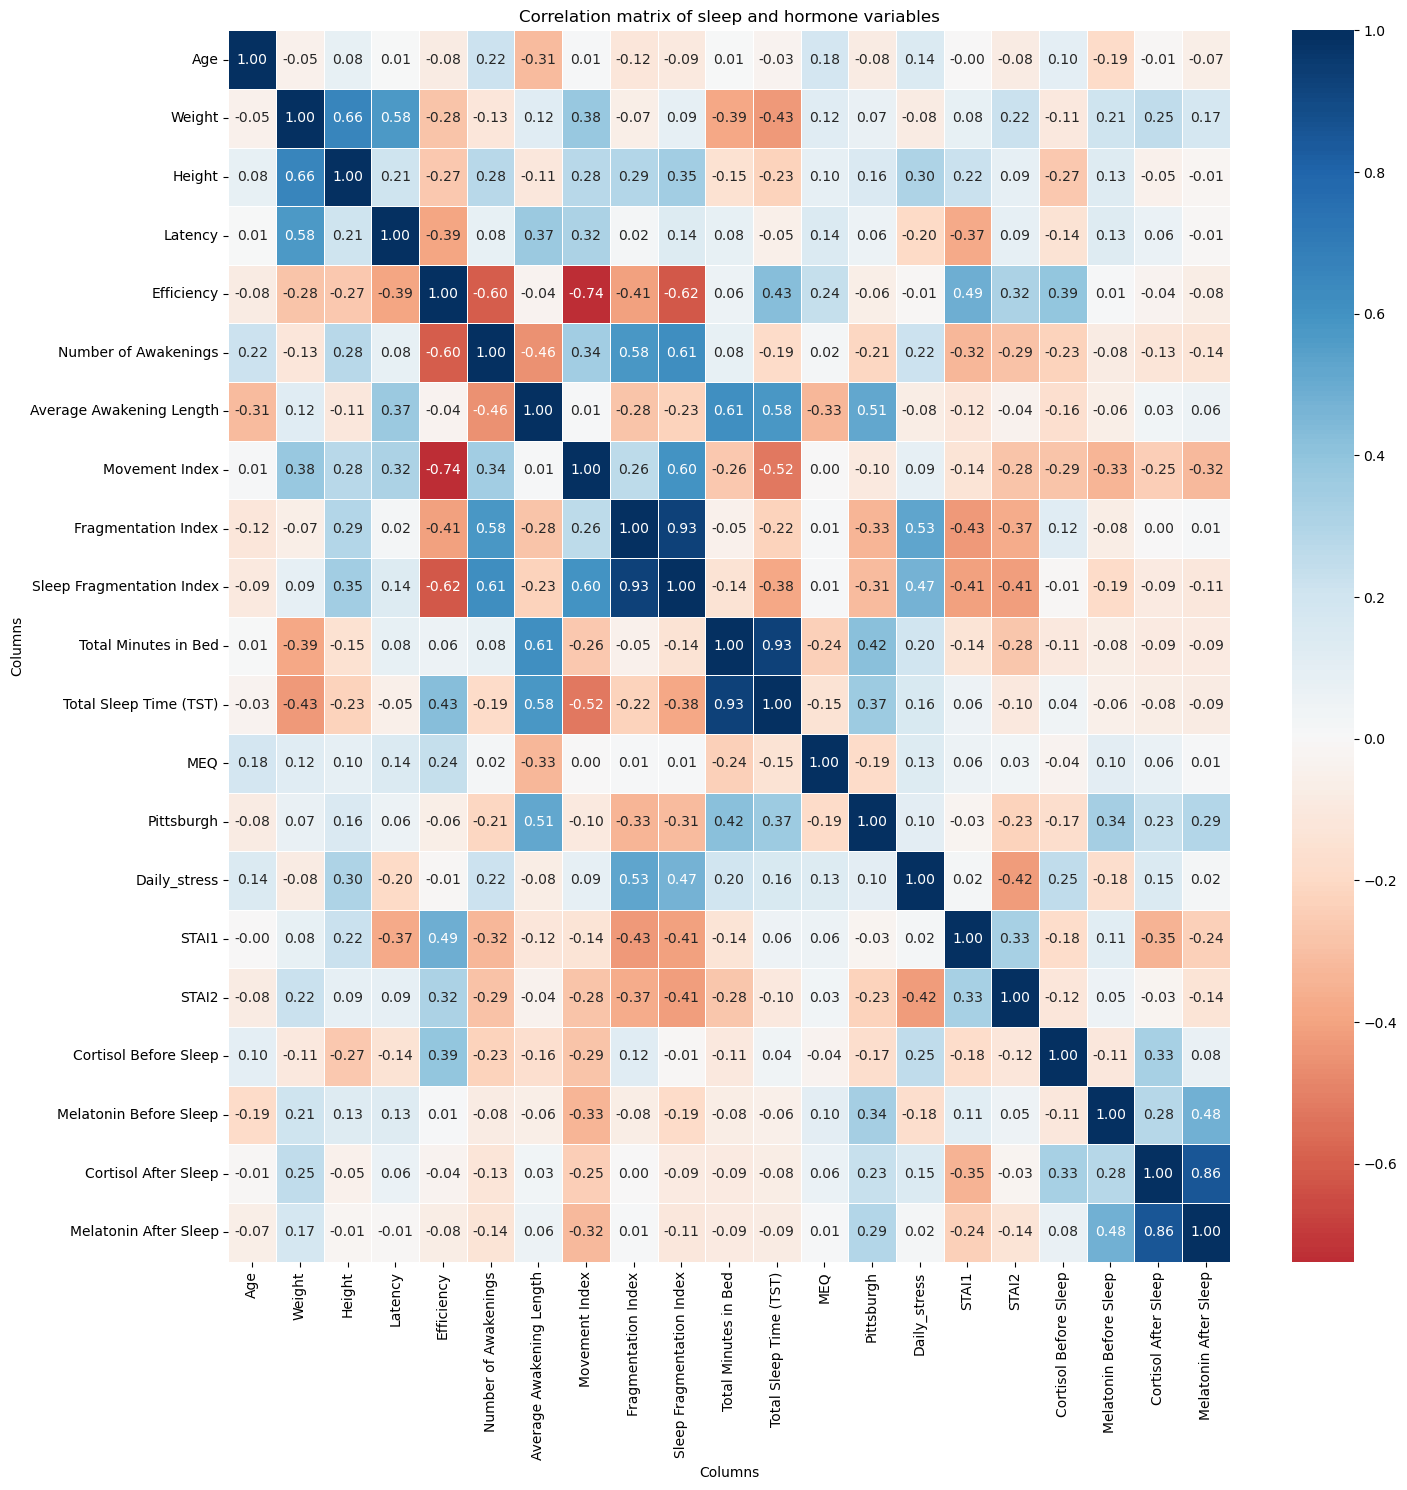

In [7]:
# correlation matrix 
numeric_cols = df1.select_dtypes(include=[np.number]).columns
corr_matrix = df1[numeric_cols].corr()

# Create correlation matrix visualization
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', center=0, fmt='.2f', linewidths=0.7)
plt.title('Correlation matrix of sleep and hormone variables')
plt.xlabel("Columns")
plt.ylabel("Columns")
plt.tight_layout()
plt.show()

In [8]:
strong_corr = []
n = len(corr_matrix.columns)
for i in range(n):
    for j in range(i+1, n):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            strong_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_value))

print(f"{'Variable 1':<35} {'Variable 2':<35} {'Correlation':<15}")
for var1, var2, corr in strong_corr:
    print(f"{var1:<35} {var2:<35} {corr:<15.4f}")


Variable 1                          Variable 2                          Correlation    
Efficiency                          Movement Index                      -0.7382        
Fragmentation Index                 Sleep Fragmentation Index           0.9306         
Total Minutes in Bed                Total Sleep Time (TST)              0.9261         
Cortisol After Sleep                Melatonin After Sleep               0.8567         


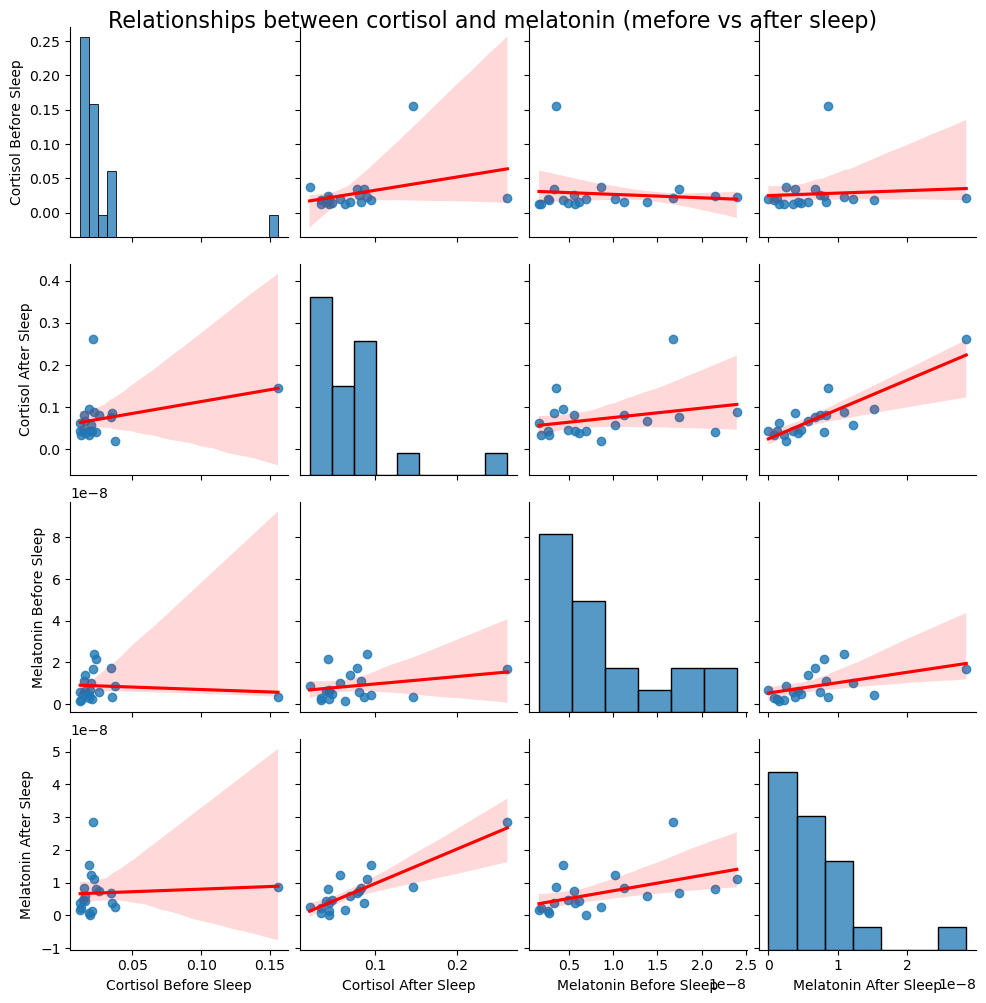

In [9]:
# From this, we see that the level of cortisol and melatonin after sleep is positively correlated.
# Let's further examine the relation of melatonin and corisol. 
# pair plot
hormone_df = df1[['Cortisol Before Sleep', 'Cortisol After Sleep', 'Melatonin Before Sleep', 'Melatonin After Sleep']].copy()
sns.pairplot(hormone_df, kind='reg', plot_kws={'line_kws':{'color':'red'}})

plt.suptitle('Relationships between cortisol and melatonin (mefore vs after sleep)', y=1, fontsize=16)
plt.show()


In [10]:
# In the majority cases, cortisol level slightly increase after sleep. 
# However, It seems like there is no signicant relation apart from the after sleep data of two hormones. 
# Let's see if their relationship is statistically significant.
# As the sample size is small (N=20), we use Bonferroni-corrected p-value: 0.05/20 = 0.0025.

cortisol_after = df1['Cortisol After Sleep']
melatonin_after = df1['Melatonin After Sleep']

# Use Person
print(stats.pearsonr(cortisol_after, melatonin_after))

# Use Spearman 
print(stats.spearmanr(cortisol_after, melatonin_after))

# The p-value in both cases are smaller than 0.0025. 
# Therefore, the positive correlation between melatonin and cortisol after sleep is statistically significant here.


PearsonRResult(statistic=0.8566907486731045, pvalue=1.4223262325502025e-06)
SignificanceResult(statistic=0.7203007518796991, pvalue=0.0003412328956726316)


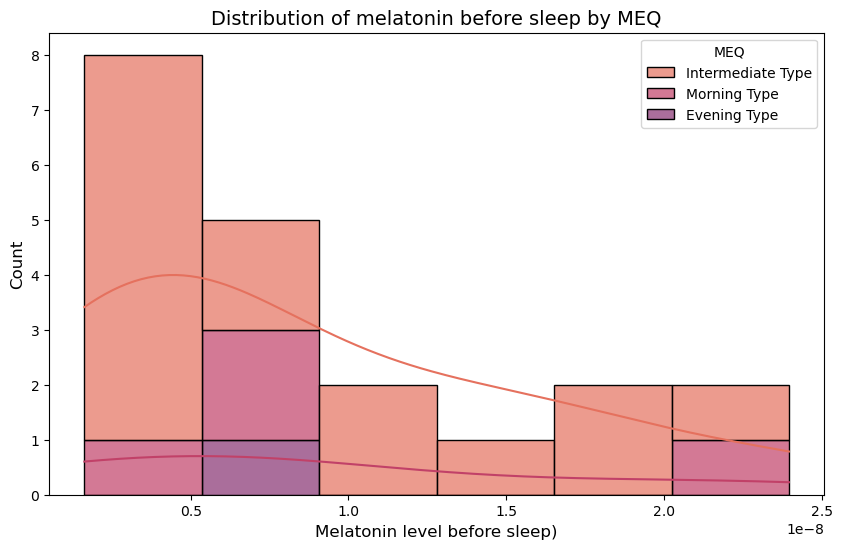

In [11]:
def classify_meq(score):
    if score <= 41: return 'Evening Type'
    elif score >= 59: return 'Morning Type'
    else: return 'Intermediate Type'

warnings.simplefilter(action='ignore', category=FutureWarning)

# Hormone levels vs sleeping schedule. 
hue = df1['MEQ'].apply(classify_meq)

plt.figure(figsize=(10, 6))

sns.histplot(data=df1, x='Melatonin Before Sleep', hue=hue, multiple='stack', kde=True,palette='flare', alpha=0.7)

plt.title('Distribution of melatonin before sleep by MEQ', fontsize=14)
plt.xlabel('Melatonin level before sleep)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Cannot conclude a significant interpretation here. 

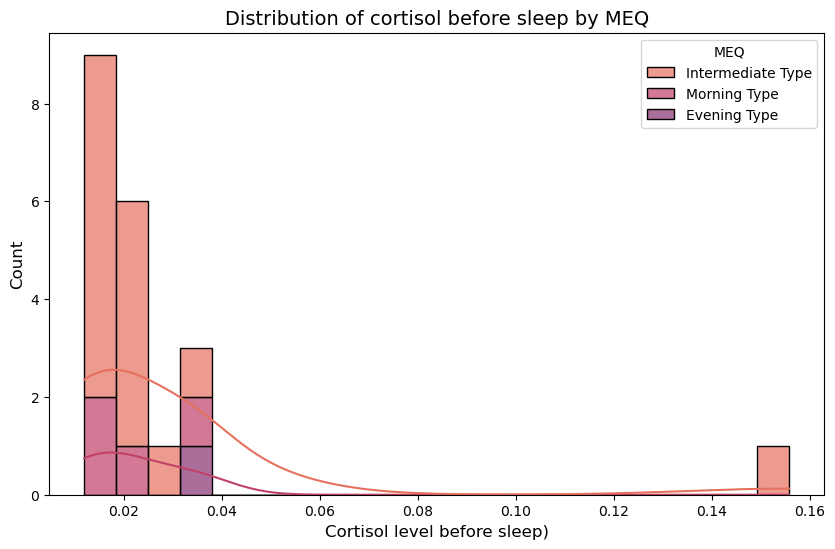

In [12]:
plt.figure(figsize=(10, 6))

sns.histplot(data=df1, x='Cortisol Before Sleep', hue=hue, multiple='stack', kde=True,palette='flare', alpha=0.7)

plt.title('Distribution of cortisol before sleep by MEQ', fontsize=14)
plt.xlabel('Cortisol level before sleep)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()
# One possible outline, maybe a very stressful person.
# Cannot conclude a clear result here. 

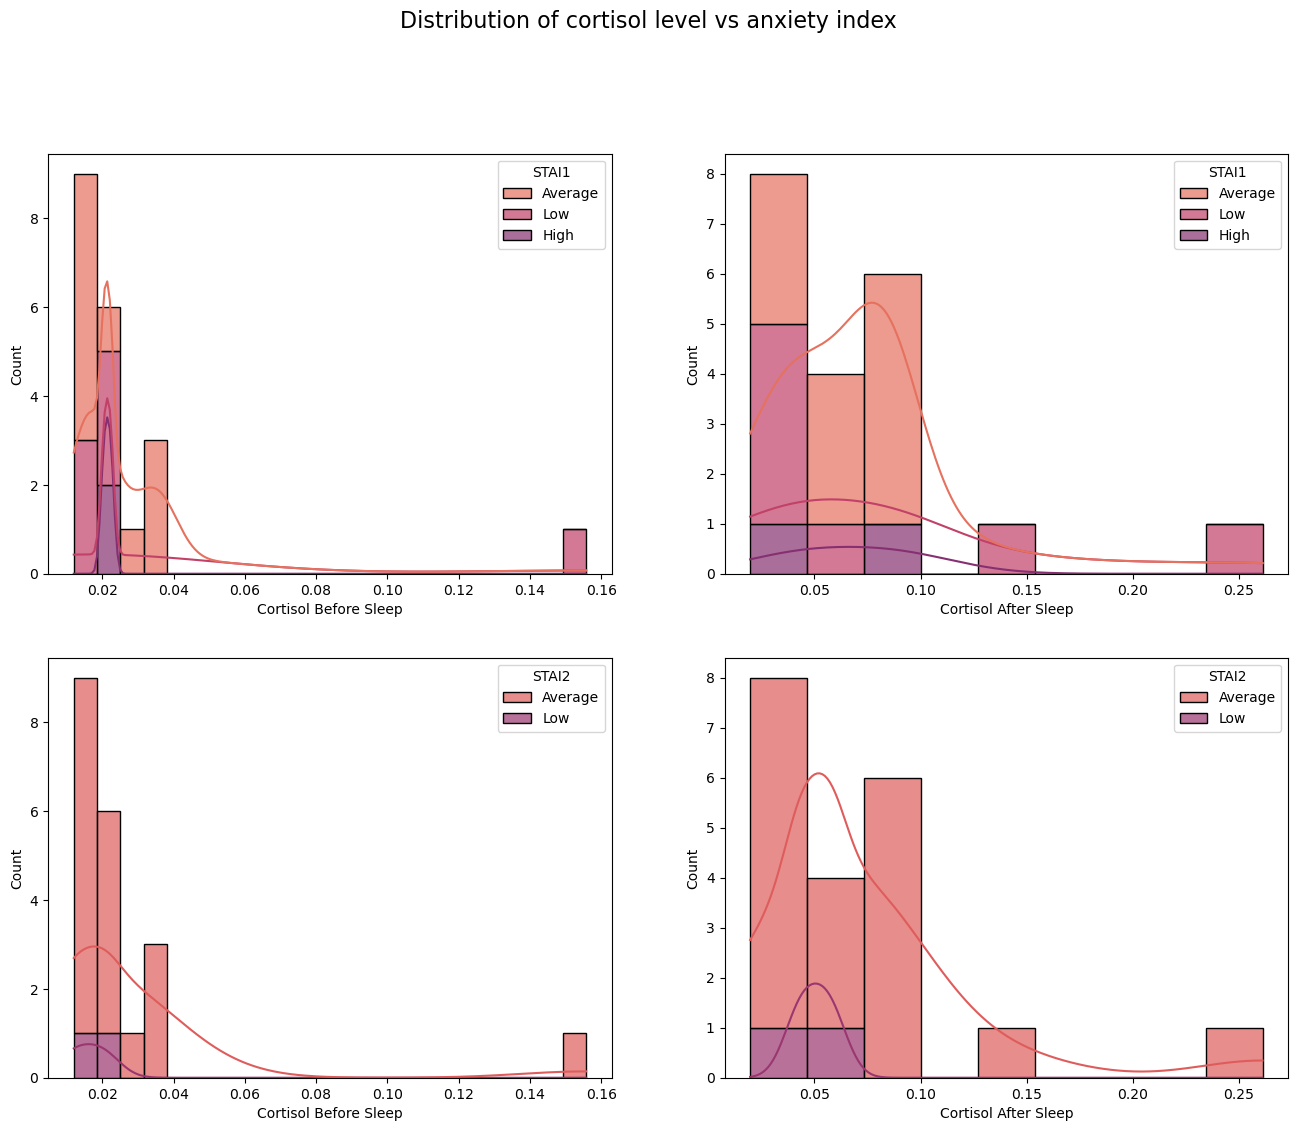

In [13]:
# Cortisol level vs STAI1 and STAI2
def classify_stai(score):
    if score < 31: return 'Low'
    elif score <= 49: return 'Average'
    else: return 'High'

stai1 = df1['STAI1'].apply(classify_stai)
stai2 = df1['STAI2'].apply(classify_stai)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.histplot(data=df1, x='Cortisol Before Sleep', hue=stai1, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[0,0])
sns.histplot(data=df1, x='Cortisol After Sleep', hue=stai1, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[0,1])
sns.histplot(data=df1, x='Cortisol Before Sleep', hue=stai2, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[1,0])
sns.histplot(data=df1, x='Cortisol After Sleep', hue=stai2, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[1,1])

plt.suptitle('Distribution of cortisol level vs anxiety index', fontsize=16, y=1)
plt.show()

In [14]:
# From the plot we see a relatively clear increase pattern of cortisol level before and after sleep
# Let's test this. 
# H0: cortisol level before sleep = after sleep. => one tailed t-test
# H1: cortisol level before sleep < after sleep

t_stat, p2 = stats.ttest_rel(df1['Cortisol After Sleep'], df1['Cortisol Before Sleep'])

# 3. Adjust for One-Tailed Test
p = p2 / 2

print(t_stat, p)
# Reject null hypothesis with alpha = 0.05. 
# Cortisol level before sleep is statistical significantlly smaller than that of after sleep.

3.8883610385738816 0.0004943734618272716


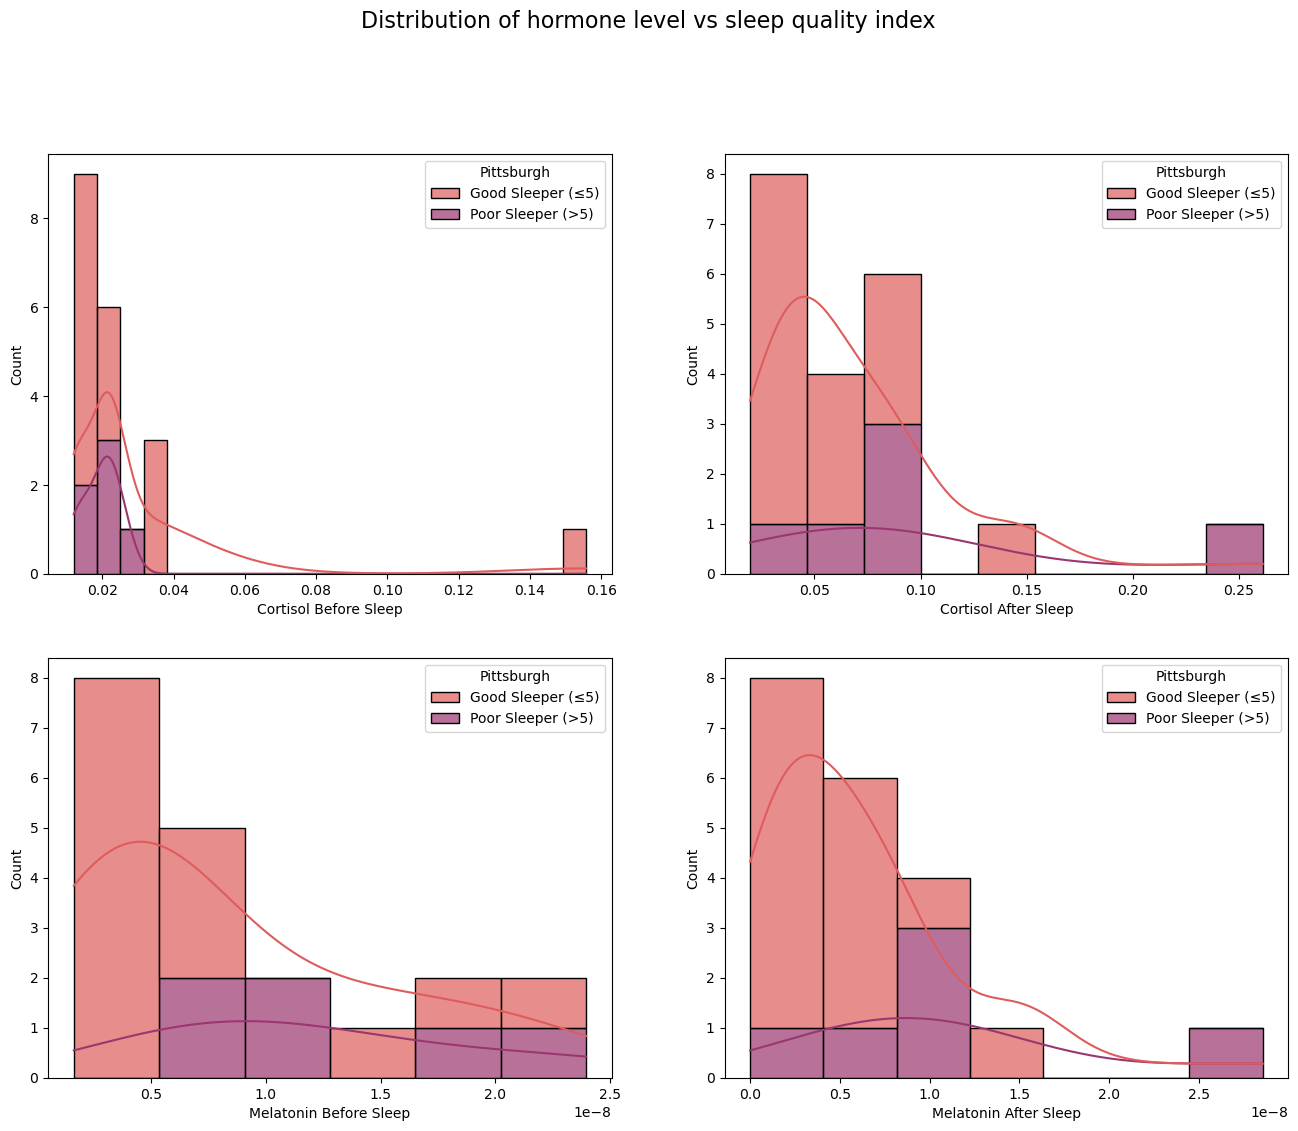

In [15]:
# hormone level vs sleep quality
def classify_psqi(score):
    if score <= 5: return 'Good Sleeper (≤5)'
    else: return 'Poor Sleeper (>5)'

psqi = df1['Pittsburgh'].apply(classify_psqi)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.histplot(data=df1, x='Cortisol Before Sleep', hue=psqi, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[0,0])
sns.histplot(data=df1, x='Cortisol After Sleep', hue=psqi, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[0,1])
sns.histplot(data=df1, x='Melatonin Before Sleep', hue=psqi, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[1,0])
sns.histplot(data=df1, x='Melatonin After Sleep', hue=psqi, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[1,1])

plt.suptitle('Distribution of hormone level vs sleep quality index', fontsize=16, y=1)
plt.show()

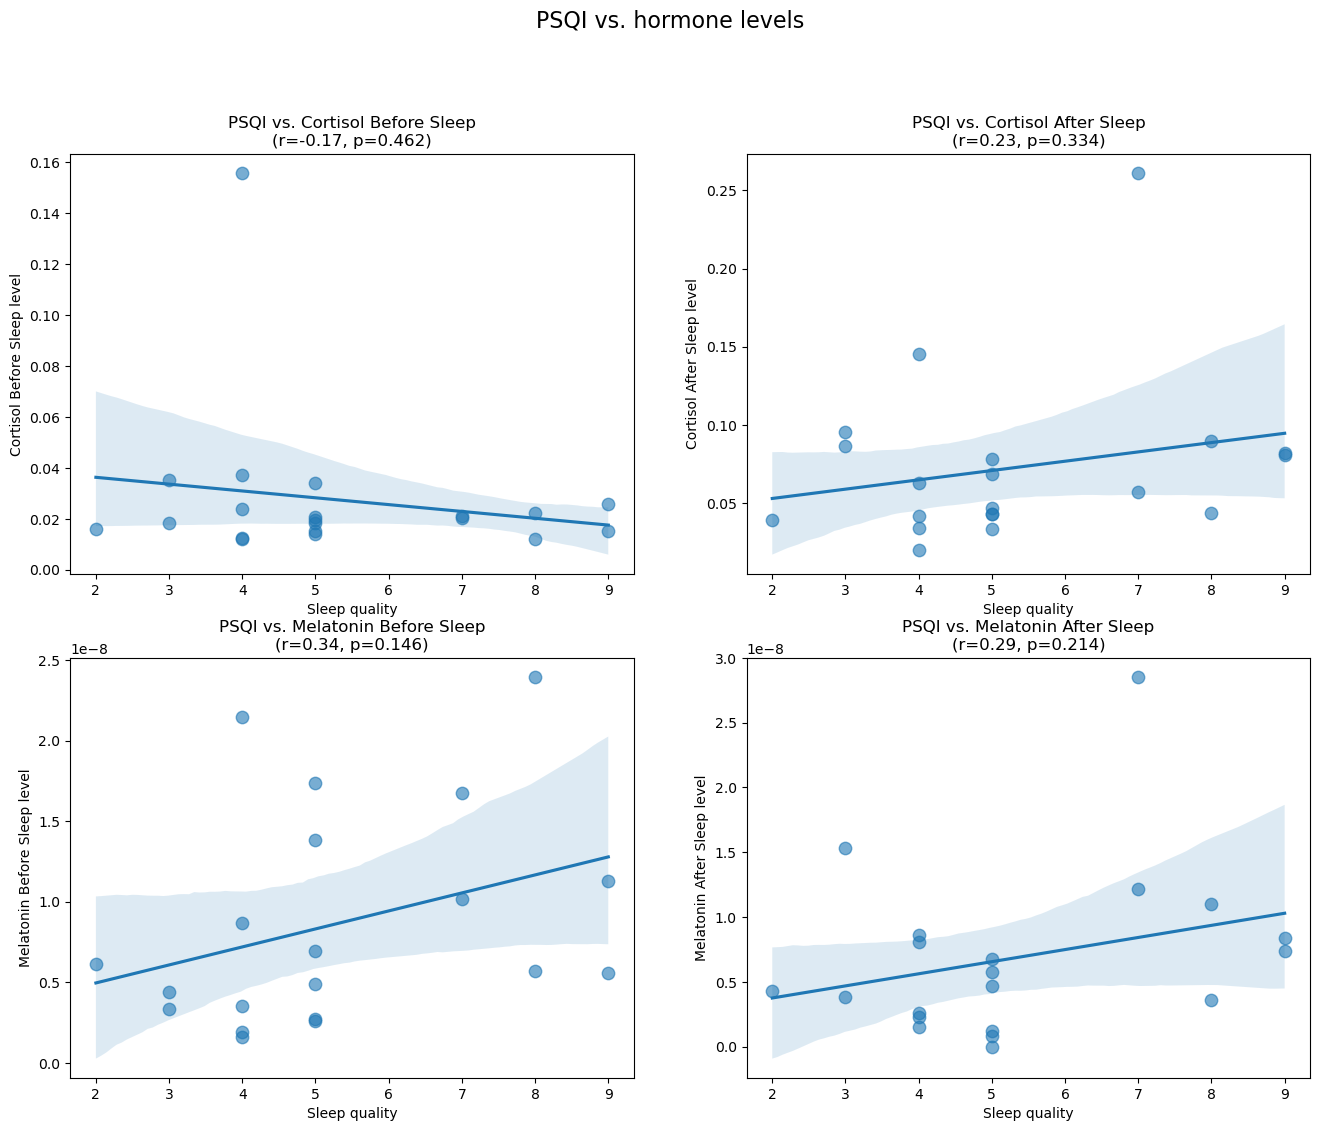

In [16]:
# relationship between sleep quality and hormone level

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes_flat = axes.flatten()

hormones = ['Cortisol Before Sleep', 'Cortisol After Sleep', 'Melatonin Before Sleep', 'Melatonin After Sleep']

for i, c in enumerate(hormones):
    ax = axes_flat[i]
    x = df1['Pittsburgh']
    y = df1[c]
    
    # use pearson 
    r, p = stats.pearsonr(x, y)

    sns.regplot(data=df1, x='Pittsburgh', y=c, ax=ax, scatter_kws={'s': 80, 'alpha': 0.6})
    
    ax.set_title(f'PSQI vs. {c}\n(r={r:.2f}, p={p:.3f})')
    ax.set_xlabel('Sleep quality')
    ax.set_ylabel(f'{c} level')

plt.suptitle('PSQI vs. hormone levels', fontsize=16, y=1)
plt.show()

# not statistically significant. 
# However the lelvel of melatonin before sleep does show postive correlation with the sleep quality. 
# This feature could be worth considering if we have more data. 
# Melatonin level seems to have more impact on sleep quality. However, the data is not significant enough. 


In fold 1, RMSE = 0.11459594106724326
In fold 2, RMSE = 0.04570318038007834
In fold 3, RMSE = 0.03044071093146299
In fold 4, RMSE = 0.043541637632393715
In fold 5, RMSE = 0.20231871784754854


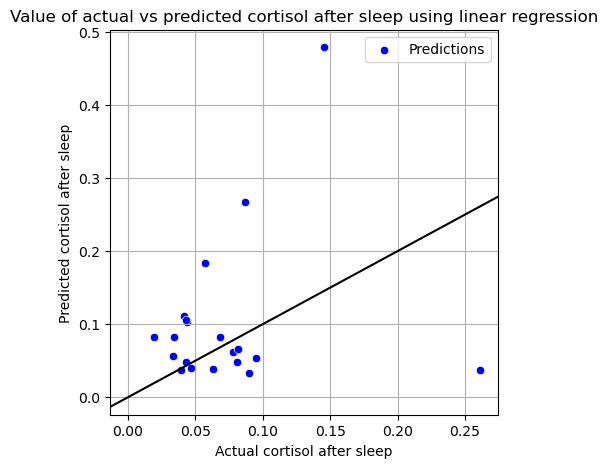

In [17]:
# Predict level of cortisol after sleep based on 
# MEQ, sleep efficiency, cortisol level before sleep, stress level, and STAI.
# As the sample size is small here, we only opt for most relevant features. 

features = ['MEQ', 'Efficiency', 'Cortisol Before Sleep', 'Daily_stress', 'STAI1']
target = 'Cortisol After Sleep'
df1_4ml = df1[features + [target]].copy()
X = df1_4ml[features]
y = df1_4ml[target]

# Use k-fold cross validation 
# Use linear regression 
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
all_y_pred = []
all_y_test = []

for fold, (train_i, test_i) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_i], X.iloc[test_i]
    y_train, y_test = y.iloc[train_i], y.iloc[test_i]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    all_y_pred.append(y_pred)
    all_y_test.append(y_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'In fold {fold+1}, RMSE = {rmse}')
    
plt.figure(figsize=(5, 5))
test_val = pd.concat(all_y_test)    
pred_val = np.concatenate(all_y_pred) 

sns.scatterplot(x=test_val, y=pred_val, color='blue', label='Predictions')
plt.axline((0, 0), slope=1, color = "black")
plt.title('Value of actual vs predicted cortisol after sleep using linear regression')
plt.xlabel('Actual cortisol after sleep')
plt.ylabel('Predicted cortisol after sleep')
plt.legend()
plt.grid()
plt.show()

In fold 1, RMSE = 0.1108311361611448
In fold 2, RMSE = 0.02258803106933614
In fold 3, RMSE = 0.02039604248952681
In fold 4, RMSE = 0.0332742180080698
In fold 5, RMSE = 0.040053996472883636


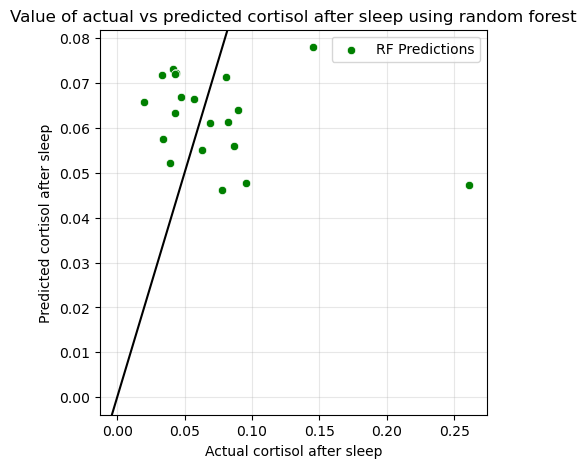

In [18]:
# Use random forest
all_y_pred2 = []
all_y_test2 = []

for fold, (train_i, test_i) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_i], X.iloc[test_i]
    y_train, y_test = y.iloc[train_i], y.iloc[test_i]
    
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    all_y_pred2.append(y_pred)
    all_y_test2.append(y_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'In fold {fold+1}, RMSE = {rmse}')

test_val2 = pd.concat(all_y_test2)    
pred_val2 = np.concatenate(all_y_pred2) 

plt.figure(figsize=(5, 5))
sns.scatterplot(x=test_val2, y=pred_val2, color='green', label='RF Predictions')
plt.axline((0, 0), slope=1, color="black")

plt.title('Value of actual vs predicted cortisol after sleep using random forest')
plt.xlabel('Actual cortisol after sleep')
plt.ylabel('Predicted cortisol after sleep')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# Part 2: Examine activities before sleep and hormone level before sleep.

def extract_time(day, time_str):
    if time_str == '24:00': 
        time_str = '00:00'
        day += 1
        
    ref_date = datetime(2025, 12, (23 + day))
    
    return datetime.combine(ref_date.date(), datetime.strptime(time_str, '%H:%M').time())

def is_earlier(time1, time2):
    return time1 < time2
    
def duration(start, end, user, j):
    if end < start:
        end += timedelta(days=1)
    duration = end-start
    return duration.total_seconds()/60 # measured in minutes

df2 = df1[['user_id', 'Pittsburgh', 'Melatonin Before Sleep', 'Cortisol Before Sleep']].copy()
activities = ['1. Sleep', '2. Laying down', '3. Sitting', '4. Light movement', '5. Medium movement', '6. Heavy movement', 
              '7. Eating', '8. Small screen usage', '9. Large screen usage', '10. caffein intake', '11. Smoke', '12. Drink alcohol']

for act in activities:
    df2[act ] = 0.0

for i, user in enumerate(df2['user_id']):
    sleep_info = pd.read_csv(data_dir + '/' + user + '/' + 'sleep.csv')
    # For simplicity I only able to consider the first sleep in this case.
    sleep_time = extract_time(sleep_info.loc[0, 'Onset Date'], sleep_info.loc[0, 'Onset Time'])
    df2.loc[i, 'Sleep time'] = sleep_time
    #print(i, user, sleep_time)
    
    # extract activities occur before sleep time
    activity_info = pd.read_csv(data_dir + '/' + user + '/' + 'Activity.csv')
    
    for j, row in activity_info.iterrows():
        try:
            act_start = extract_time(row['Day'], row['Start'])
            act_end = extract_time(row['Day'], row['End']) 
            if is_earlier(act_end, sleep_time):
                dur = duration(act_start, act_end, user, j)
                code = int(row['Activity']) - 1
                if 0 <= code < len(activities):
                    name = activities[code]
                    df2.loc[i, name] += dur
                    # print(user, j, dur, name)
        except Exception as e:
            print(f'Error: {user}, {j}, {e}') # Missing data
        
df2.info()
df2.head(5)
# print(df2)

Error: user_1, 30, strptime() argument 1 must be str, not float
Error: user_2, 20, strptime() argument 1 must be str, not float
<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 0 to 10
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_id                 20 non-null     object        
 1   Pittsburgh              20 non-null     float64       
 2   Melatonin Before Sleep  20 non-null     float64       
 3   Cortisol Before Sleep   20 non-null     float64       
 4   1. Sleep                20 non-null     float64       
 5   2. Laying down          20 non-null     float64       
 6   3. Sitting              20 non-null     float64       
 7   4. Light movement       20 non-null     float64       
 8   5. Medium movement      20 non-null     float64       
 9   6. Heavy movement       20 non-null     float64       
 10  7. Eating               20 non-null     float64  

,user_id,Pittsburgh,Melatonin Before Sleep,Cortisol Before Sleep,1. Sleep,2. Laying down,3. Sitting,4. Light movement,5. Medium movement,6. Heavy movement,7. Eating,8. Small screen usage,9. Large screen usage,10. caffein intake,11. Smoke,12. Drink alcohol,Sleep time
0,user_1,5.0,1.738385e-08,0.034137,5.0,257.0,50.0,10.0,10.0,130.0,60.0,45.0,13.0,50.0,0.0,0.0,2025-12-25 00:46:00
1,user_2,7.0,1.676342e-08,0.021186,2.0,44.0,81.0,17.0,0.0,52.0,160.0,30.0,2.0,0.0,0.0,10.0,2025-12-25 00:54:00
2,user_3,8.0,5.714439e-09,0.012142,0.0,80.0,330.0,10.0,55.0,45.0,25.0,0.0,15.0,0.0,0.0,0.0,2025-12-24 22:32:00
3,user_4,4.0,2.149747e-08,0.023772,1.0,155.0,0.0,0.0,0.0,110.0,235.0,120.0,10.0,0.0,0.0,5.0,2025-12-25 01:01:00
4,user_5,8.0,2.396239e-08,0.022310,0.0,300.0,50.0,0.0,0.0,110.0,135.0,0.0,10.0,0.0,0.0,0.0,2025-12-24 23:56:00


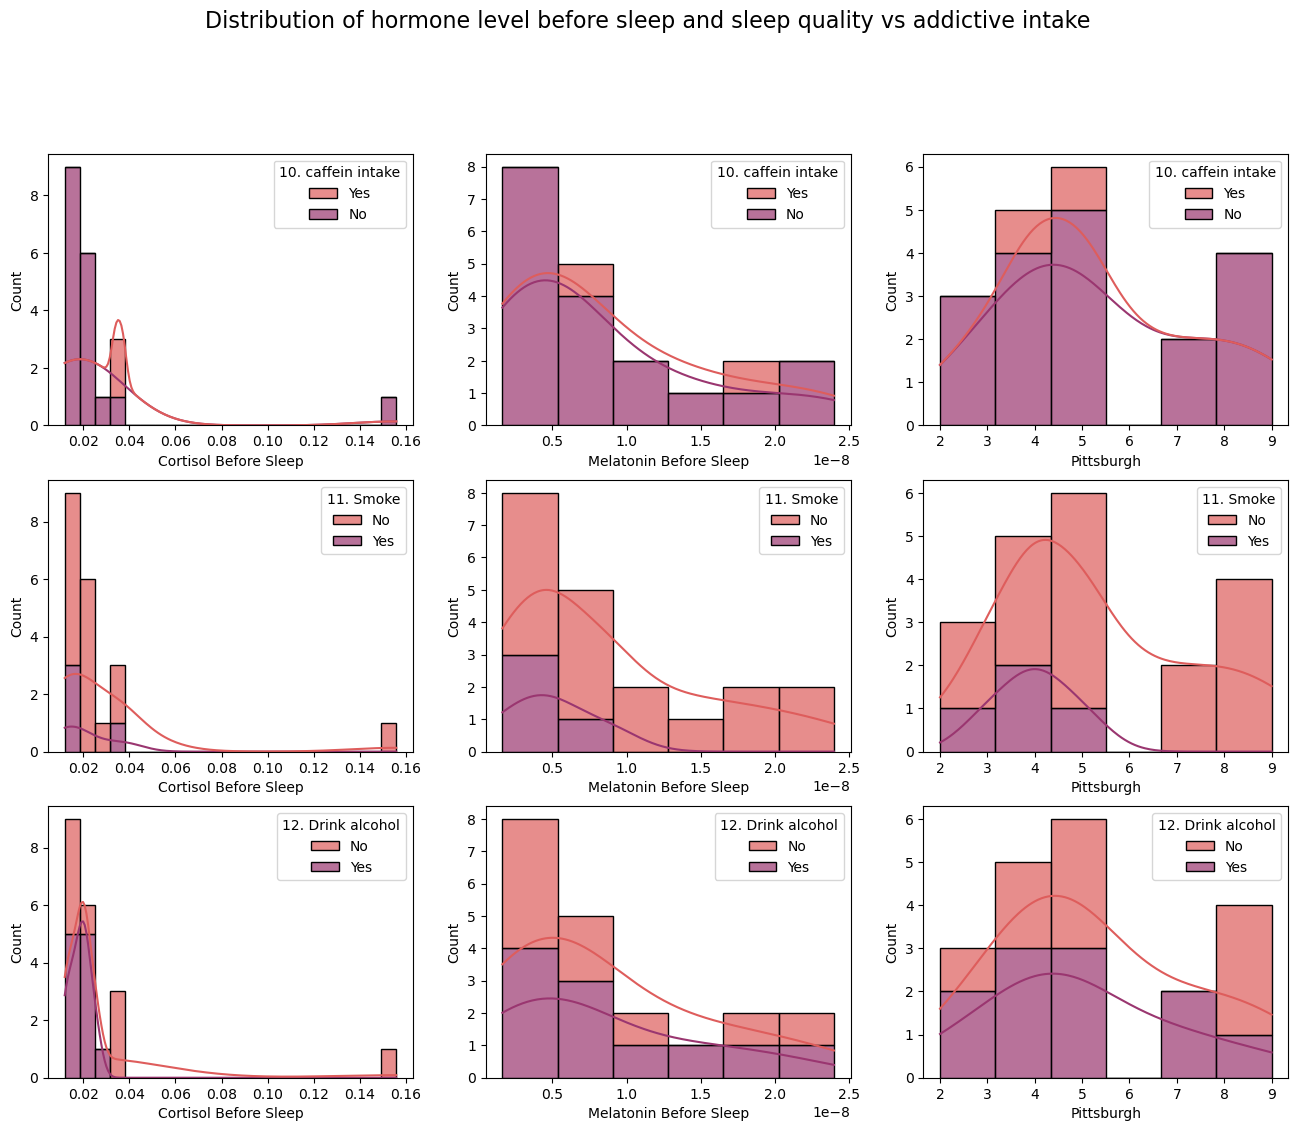

In [20]:
# hormone level and sleep quality vs addictive intake
def classify(duration):
    if duration > 0: return 'Yes'
    else: return 'No'

caffein = df2['10. caffein intake'].apply(classify)
smoke = df2['11. Smoke'].apply(classify)
alcohol = df2['12. Drink alcohol'].apply(classify)

# this plotting code is reused from the code in part 1
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
sns.histplot(data=df2, x='Cortisol Before Sleep', hue=caffein, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[0,0])
sns.histplot(data=df2, x='Melatonin Before Sleep', hue=caffein, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[0,1])
sns.histplot(data=df2, x='Pittsburgh', hue=caffein, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[0,2])

sns.histplot(data=df2, x='Cortisol Before Sleep', hue=smoke, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[1,0])
sns.histplot(data=df2, x='Melatonin Before Sleep', hue=smoke, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[1,1])
sns.histplot(data=df2, x='Pittsburgh', hue=smoke, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[1,2])

sns.histplot(data=df2, x='Cortisol Before Sleep', hue=alcohol, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[2,0])
sns.histplot(data=df2, x='Melatonin Before Sleep', hue=alcohol, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[2,1])
sns.histplot(data=df2, x='Pittsburgh', hue=alcohol, multiple='stack', kde=True,palette='flare', alpha=0.7, ax=axes[2,2])


plt.suptitle('Distribution of hormone level before sleep and sleep quality vs addictive intake', fontsize=16, y=1)
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, 0 to 10
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Cortisol Before Sleep   12 non-null     float64
 1   Melatonin Before Sleep  12 non-null     float64
 2   Pittsburgh              12 non-null     float64
 3   9. Large screen usage   12 non-null     float64
dtypes: float64(4)
memory usage: 520.0 bytes


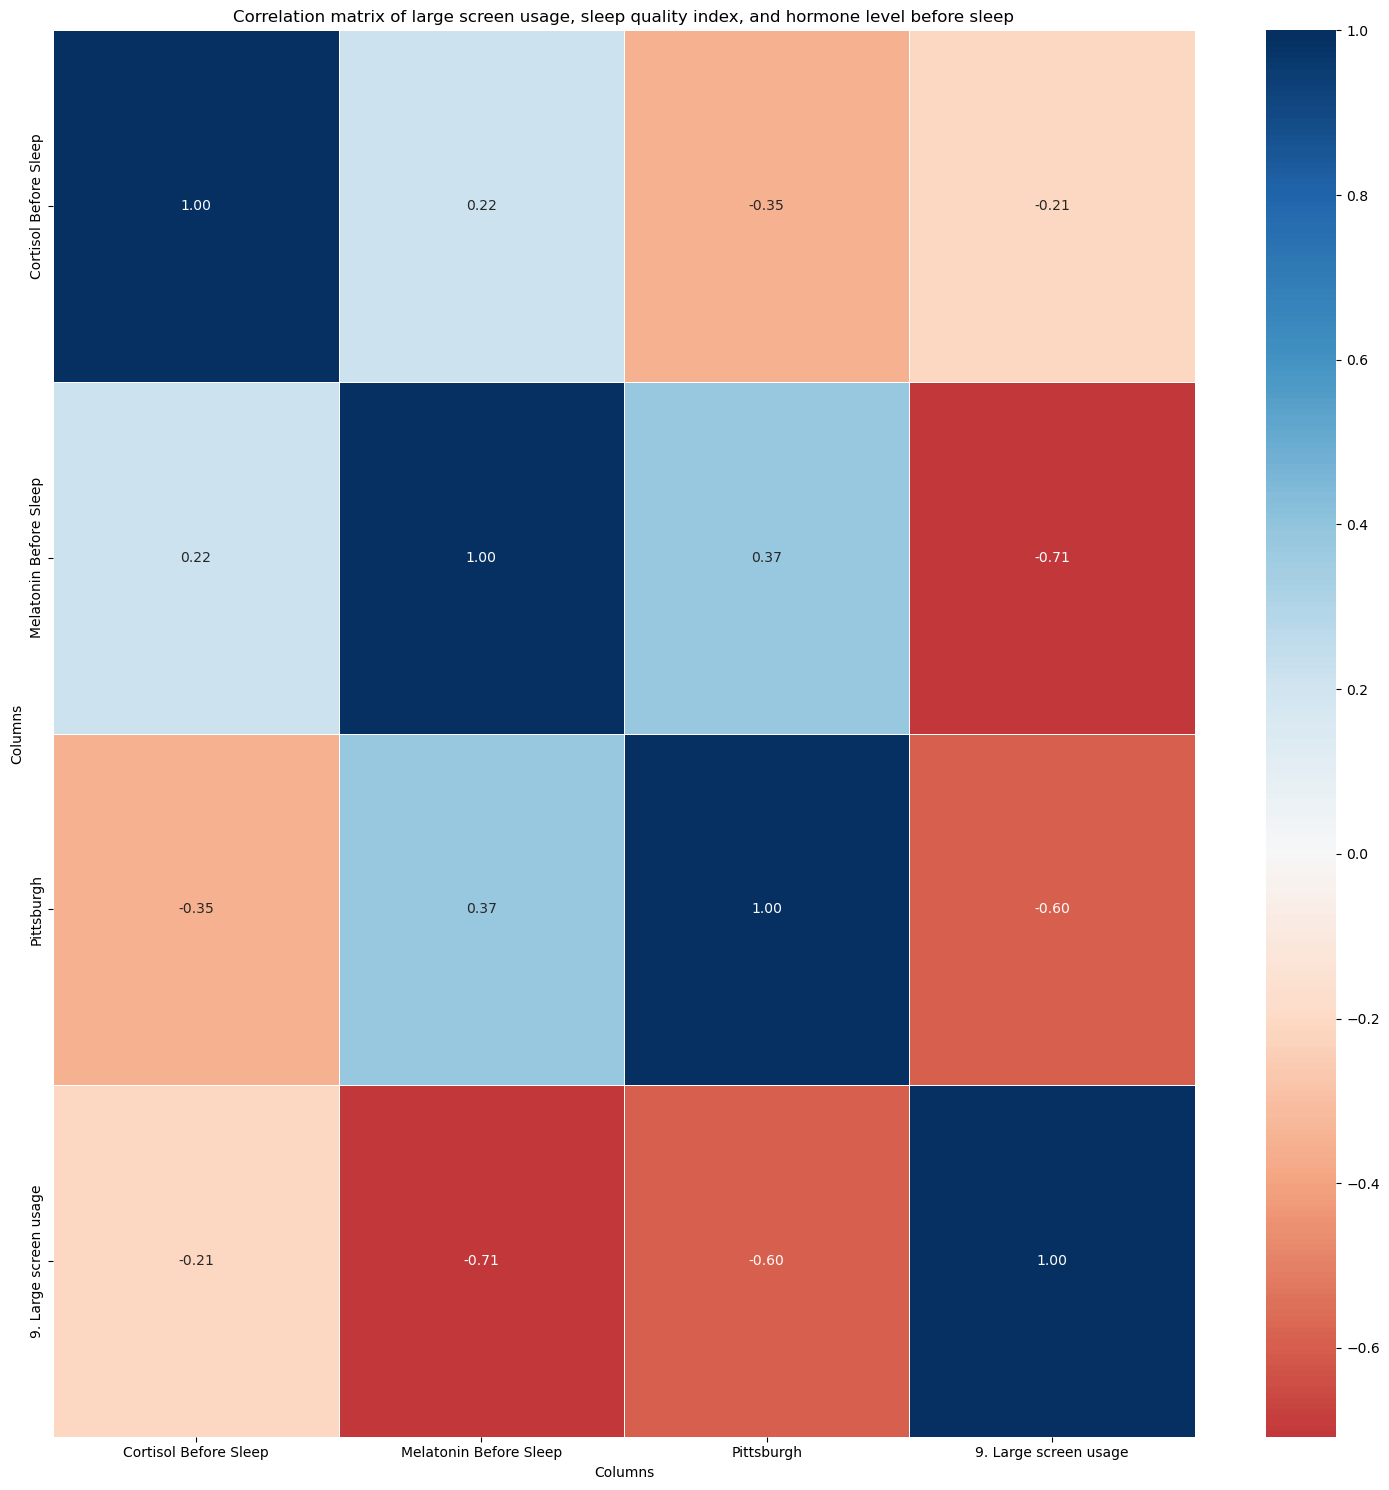

In [21]:
# screen time vs hormones level and sleep quality
# large screen usage
large_screen_df = df2[df2['9. Large screen usage'] != 0].copy()
large_screen_df = large_screen_df[['Cortisol Before Sleep', 'Melatonin Before Sleep', 'Pittsburgh', '9. Large screen usage']]
large_screen_df.info()

large_screen_corr_matrix = large_screen_df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(large_screen_corr_matrix, annot=True, cmap='RdBu', center=0, fmt='.2f', linewidths=0.7)
plt.title('Correlation matrix of large screen usage, sleep quality index, and hormone level before sleep')
plt.xlabel("Columns")
plt.ylabel("Columns")
plt.tight_layout()
plt.show()

# Large screen usage have negative correlation with sleep quality and melatonin level before sleep


In [31]:
large_screen_time = large_screen_df['9. Large screen usage'].dropna()
melatonin = large_screen_df['Melatonin Before Sleep'].dropna()

# Use Person
print(stats.pearsonr(large_screen_time, melatonin))

# Use Spearman 
print(stats.spearmanr(large_screen_time, melatonin))

PearsonRResult(statistic=-0.7078230940575241, pvalue=0.010009830344487845)
SignificanceResult(statistic=-0.7817095248764386, pvalue=0.0026700659830202586)


<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, 0 to 10
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Cortisol Before Sleep   12 non-null     float64
 1   Melatonin Before Sleep  12 non-null     float64
 2   Pittsburgh              12 non-null     float64
 3   8. Small screen usage   12 non-null     float64
dtypes: float64(4)
memory usage: 520.0 bytes


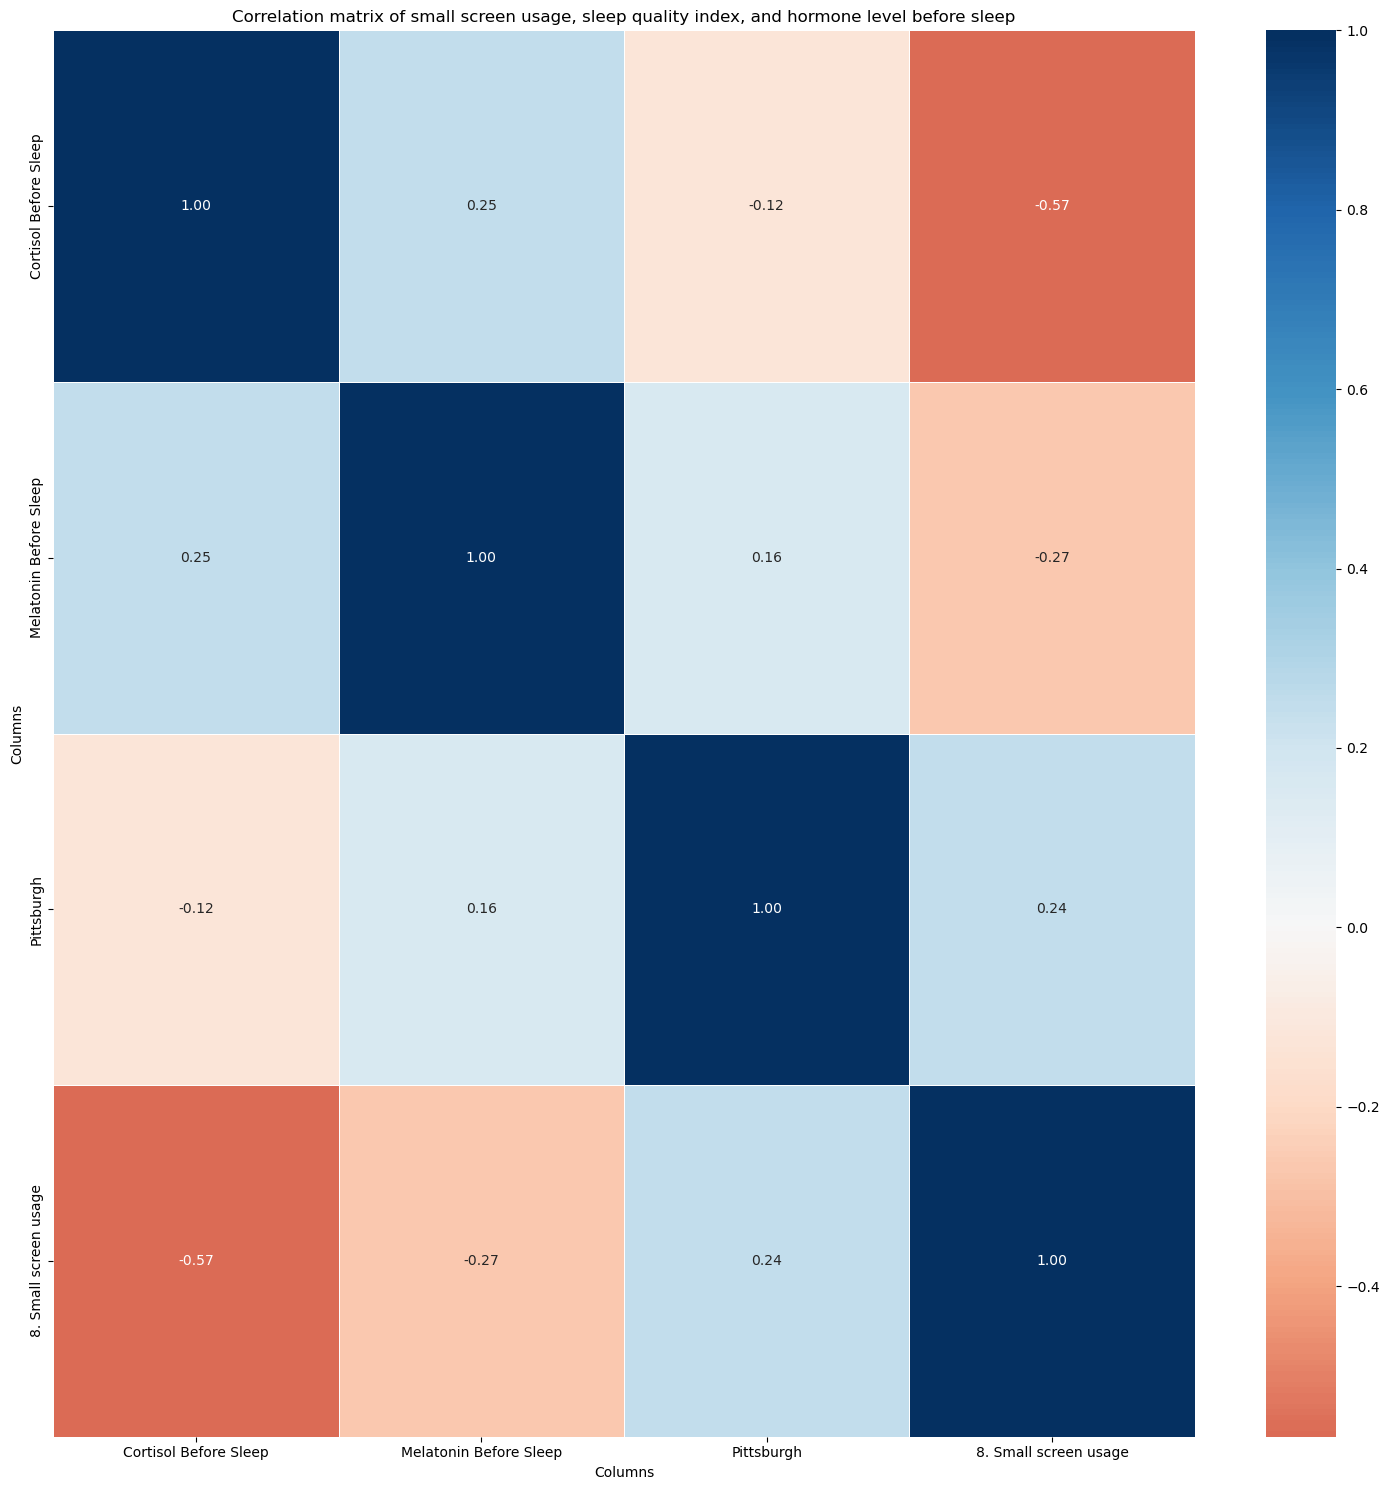

In [22]:
# small screen usage
small_screen_df = df2[df2['8. Small screen usage'] != 0].copy()
small_screen_df = small_screen_df[['Cortisol Before Sleep', 'Melatonin Before Sleep', 'Pittsburgh', '8. Small screen usage']]
small_screen_df.info()

small_screen_corr_matrix = small_screen_df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(small_screen_corr_matrix, annot=True, cmap='RdBu', center=0, fmt='.2f', linewidths=0.7)
plt.title('Correlation matrix of small screen usage, sleep quality index, and hormone level before sleep')
plt.xlabel("Columns")
plt.ylabel("Columns")
plt.tight_layout()
plt.show()

# Small screen usage before bed seems to only have large negative correlative with cortisol level before bed 


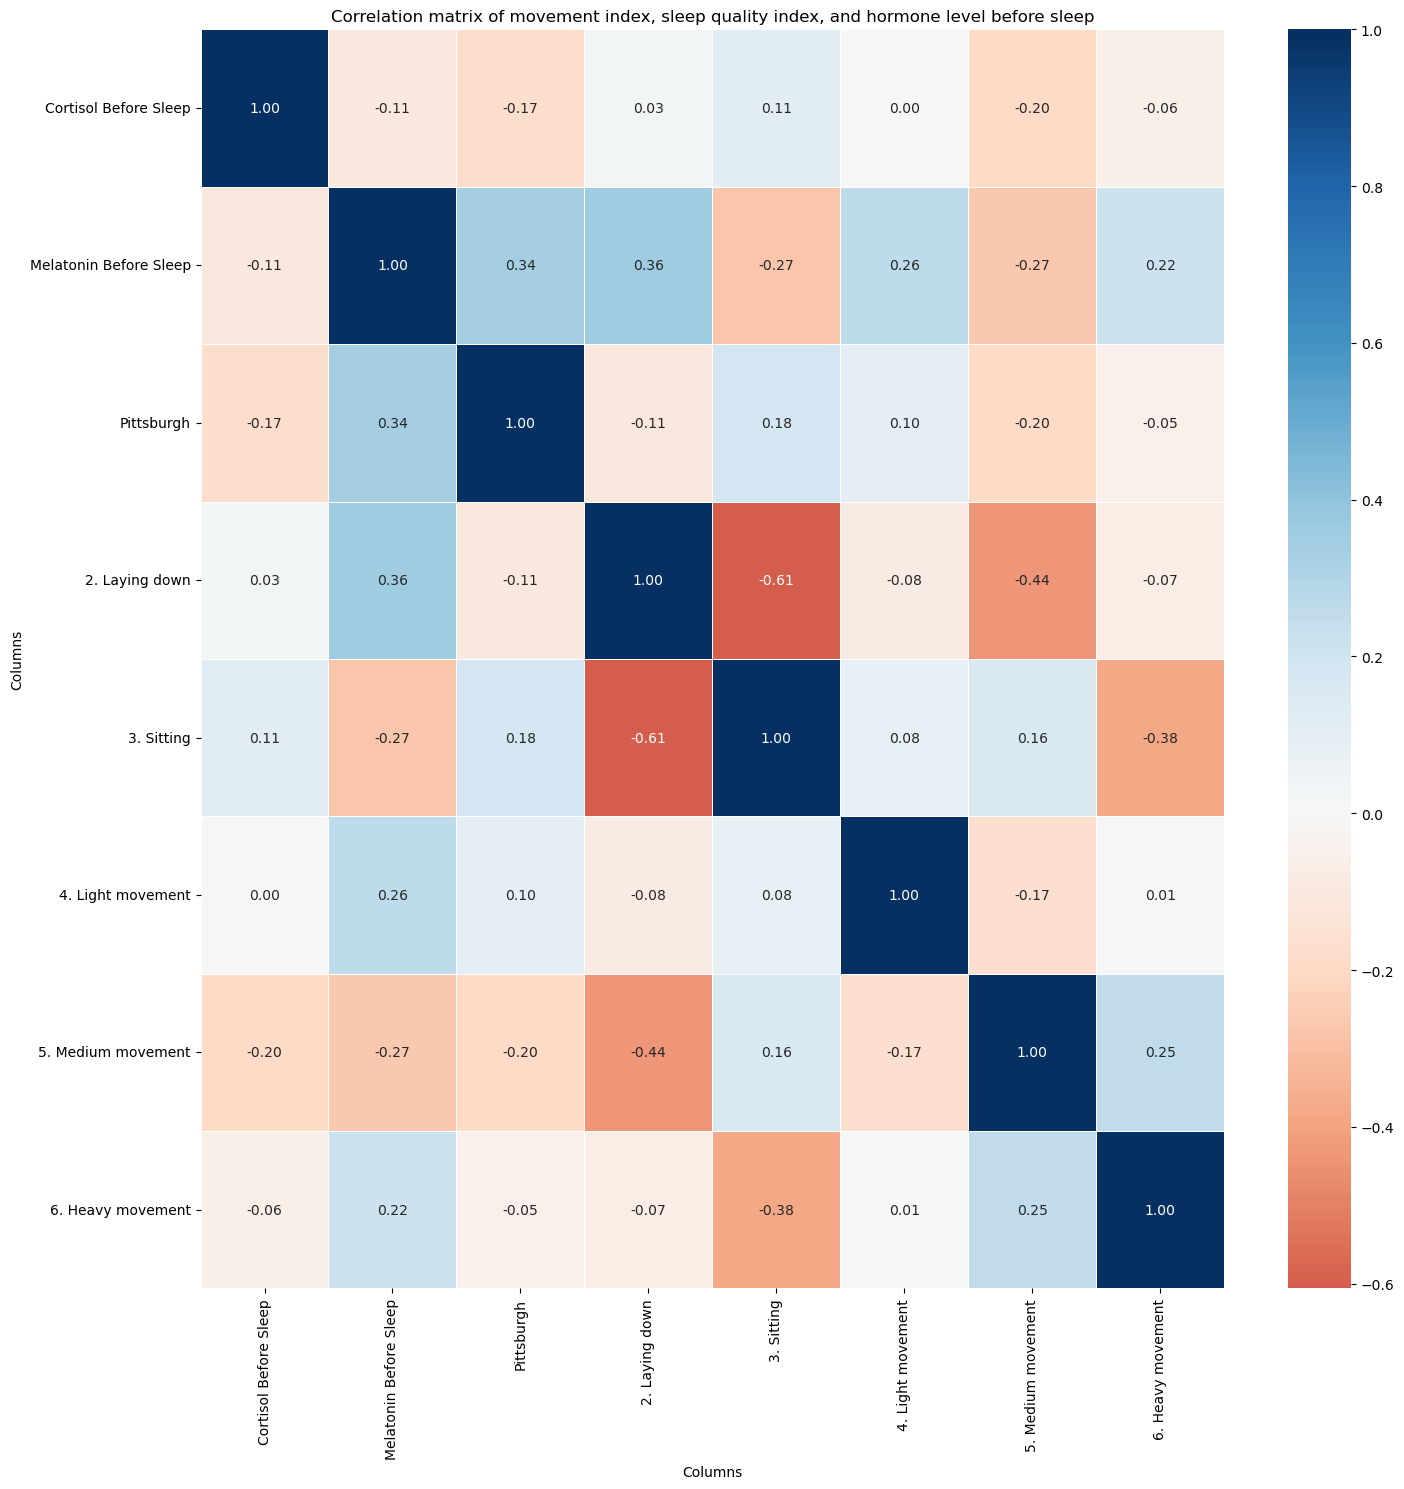

In [23]:
# movement

movement_df = df2[['Cortisol Before Sleep', 'Melatonin Before Sleep', 'Pittsburgh', '2. Laying down', '3. Sitting', '4. Light movement', '5. Medium movement', '6. Heavy movement']].copy()
movement_df['Total movement'] = movement_df.sum(axis=1)
movement_df = movement_df[movement_df['Total movement'] != 0]
# movement_df.info()
# print(movement_df)

move_cols = ['2. Laying down', '3. Sitting', '4. Light movement', '5. Medium movement', '6. Heavy movement']
movement_df[move_cols] = movement_df[move_cols].div(movement_df['Total movement'], axis=0) * 100
movement_df.drop(columns=['Total movement'], inplace=True)

# movement_df.info()

movement_corr_matrix = movement_df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(movement_corr_matrix, annot=True, cmap='RdBu', center=0, fmt='.2f', linewidths=0.7)
plt.title('Correlation matrix of movement index, sleep quality index, and hormone level before sleep')
plt.xlabel("Columns")
plt.ylabel("Columns")
plt.tight_layout()
plt.show()

# melatonin level before sleep seems to have light positive correlation with lying down activity. 
# movement level seems to have not significant impact on sleep quality. 
